In [1]:
import numpy as np
import os
import sys
sys.path.append('./../hyperAFM')
sys.path.append('./../Jessica')
sys.path.append('./../Data')
#image registration
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (AffineTransform2D,
                                   RigidTransform2D,
                                   RotationTransform2D,
                                  ScalingTransform2D, 
                                   TranslationTransform2D)
#for image processing
from scipy import signal
from scipy.ndimage import rotate
from scipy.stats import f
from util import HyperImage, load_ibw, hyperslice
#for standardizing 
from sklearn.preprocessing import scale
#linear regression package
from sklearn import linear_model 
#for randomly splitting data into training and test sets
from sklearn.model_selection import train_test_split
#PCA
from sklearn.decomposition import PCA as sklearnPCA
#for plotting and displaying images
import matplotlib.pyplot as plt
import cmocean
%matplotlib inline
#ica nmf
from sklearn.decomposition import FastICA, NMF

### Import Images and laser profile

In [2]:
#import hyperspectral image 
#'./../../Desktop/20170926_P3HTPMMA/Film15_0010.txt'
#'./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0026.txt'
hyperimage=HyperImage('./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0026.txt')
hyper=hyperimage.hyper_image
hypertopo=hyperimage.channel_data[:,:,0]
#flatten
hypertopo=signal.detrend(hypertopo, axis=1, type="linear")
exp_wavenumber=hyperimage.wavelength_data
hyperint=signal.detrend(hyperslice(hyperimage, start=760, stop=1875), axis=1, type="linear")

#import corresponding cAFM image
#'./../../Desktop/20170928_cAFM_PMMAP3HT_corr/Film15cAFM_1V_0001.ibw'
#'./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/cAFM3_0000.ibw'
cAFMimage=load_ibw('./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/cAFM3_0000.ibw')
cAFMtopo=cAFMimage[:,:,0]
cAFMtopo_mean=cAFMtopo.mean()
#flatten
cAFMtopo=signal.detrend(cAFMtopo, axis=1, type="linear")
cAFM=cAFMimage[:,:,3]
#store cAFM values in list. 
cAFMlist=cAFM.reshape((65536,))

#PiFM laser profile
laser=np.loadtxt('./../Data/Q0148.txt', delimiter = '\t' )
power=laser[:,1]
laser_wavenumber=laser[:,0]
#interpolated laser power 
laserpower_interp= np.interp(exp_wavenumber, laser_wavenumber, power)

#colormap
colormap=cmocean.cm.thermal

### Function to show images

In [3]:
def show(img, cmap = 'plasma', colorbar = True):
    """Displays image with colorbar."""
    fig = plt.imshow(img, cmap = cmap)
    imgstd = img.std()
    imgmean = img.mean()
    ll = imgmean - (2*imgstd)
    ul = imgmean + (2*imgstd)
    plt.clim(ll,ul)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if colorbar == True:
        plt.colorbar()
    return 

## 1. Image Registration 

Define moving and static images. We pick the c-AFM image as the moving image because it is easiest to manipulate. 

In [5]:
static=hypertopo
moving=cAFMtopo

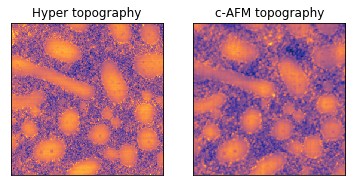

In [6]:
#display images side by side 
fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(static, cmap=colormap)
ax1.set_title('Hyper topography')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2=ax2.imshow(cAFMtopo, cmap=colormap)
ax2.set_title('c-AFM topography')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

In [7]:
#rotate c-AFM topography and current channels manually to get images closer to being aligned: 
rotated = rotate(cAFMtopo, angle = -4)
cAFMrotated = rotate(cAFM, angle = -4)

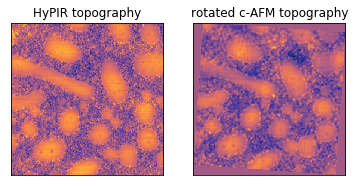

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(static, cmap=colormap)
ax1.set_title('HyPIR topography')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2=ax2.imshow(rotated, cmap=colormap)
ax2.set_title('rotated c-AFM topography')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

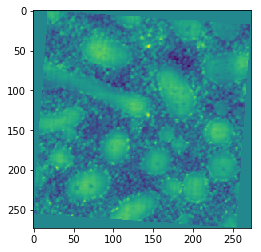

In [10]:
plt.imshow(rotated)

In [9]:
#set up parameters for affine transformation (see SI for details):
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


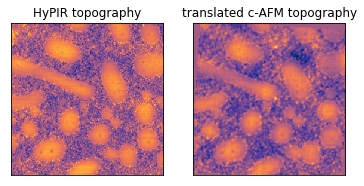

In [12]:
#optimize transformation in x-,y-space:
transform = TranslationTransform2D()
params0= None
static = hypertopo
moving = rotated
translation = affreg.optimize(static, moving, transform, params0, starting_affine=None)
transformed = translation.transform(moving)
#apply transformation to current image:
cAFM_transformed = translation.transform(cAFMrotated)
#show transformed topography 
fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(static, cmap=colormap)
ax1.set_title('HyPIR topography')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2=ax2.imshow(transformed, cmap=colormap)
ax2.set_title('translated c-AFM topography')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


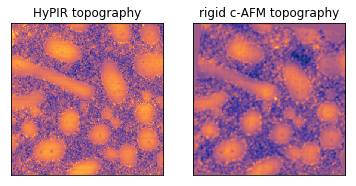

In [13]:
#use prior x-,y-transformation as starting point and optimize with respect to rotation: 
starting_affine = translation.affine
transform = RigidTransform2D() 
rigid = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
#apply transformation to c-AFM topography: 
transformed = rigid.transform(moving)
#apply transformation to current image: 
cAFM_transformed = rigid.transform(cAFMrotated)
fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(static, cmap=colormap)
ax1.set_title('HyPIR topography')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2=ax2.imshow(transformed, cmap=colormap)
ax2.set_title('rigid c-AFM topography')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


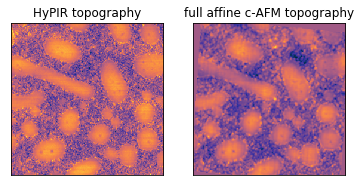

In [14]:
#use prior rigid transformation as starting point and optimize with respect to a full affine transformation: 
starting_affine = rigid.affine
transform = AffineTransform2D()
affine = affreg.optimize(static, moving, transform, params0, starting_affine = starting_affine)
#apply to c-AFM topography
transformed = affine.transform(moving)
#apply to current image: 
cAFM_transformed = affine.transform(cAFMrotated)


fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(static, cmap=colormap)
ax1.set_title('HyPIR topography')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2=ax2.imshow(transformed, cmap=colormap)
ax2.set_title('full affine c-AFM topography')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

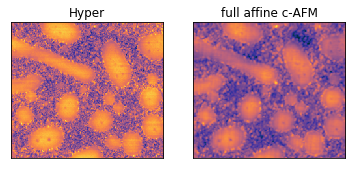

In [15]:
#show common area: 
fig, (ax1, ax2) = plt.subplots(1, 2)
im1=ax1.imshow(hypertopo[35:245, 10:245], cmap=colormap)
ax1.set_title('Hyper')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

im2=ax2.imshow(transformed[35:245, 10:245], cmap=colormap)
ax2.set_title('full affine c-AFM')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

## 2. Principal Component Analysis (PCA) 

In [16]:
def to_2d(spectralmatrix):
    """
    Takes a raw 3-D N x M x S matrix and restructures it into a laser power corrected,
    2D (NxM) x S matrix. 
    """
    xaxis=spectralmatrix.shape[0]
    yaxis=spectralmatrix.shape[1]
    zaxis=spectralmatrix[0,0,:].shape[0]
    featurematrix=np.zeros((xaxis*yaxis, zaxis))
    counter=-1
    #loop over elements in spectralmatrix 
    for x in range(xaxis):
        for y in range(yaxis):
            counter+=1 
            for z in range(zaxis):
                featurematrix[counter]=(spectralmatrix[x,y,:])/laserpower_interp
    return featurematrix

In [17]:
spectralfeat=to_2d(hyper[35:245, 10:245,:])

In [18]:
spectralfeat_std=scale(spectralfeat[:,1:], axis=0)
PCA=sklearnPCA()
PCA.fit(spectralfeat_std)
scores=PCA.transform(spectralfeat_std)
scores_maps=scores.reshape((210,235,558))

## 3. Multiple Linear Regression (MLR)

In [19]:
#split data into testing and training sets. 
cAFMshiftlist=cAFM_transformed[35:245, 10:245].reshape((49350,1))
train_x, test_x, train_y, test_y=train_test_split(scores[:,0:10],cAFMshiftlist,test_size=0.90, train_size=0.10, random_state=4)

In [20]:
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

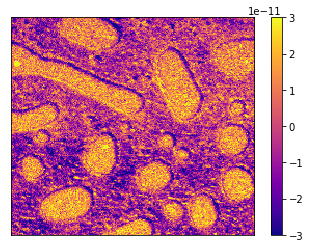

In [24]:
cAFMpred = regr.predict(scores[:,0:10])
cAFMpredimage= cAFMpred.reshape(210,235)
error = cAFMpredimage - cAFM_transformed[35:245, 10:245]
fig=plt.imshow(error, cmap='plasma')
mean = cAFMpredimage.mean()
std = cAFMpredimage.std()

plt.clim(0.3e-10, -0.3e-10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.colorbar()

## 4. Error Metrics

In [149]:
from sklearn.cluster import KMeans

In [187]:
kmeans=KMeans(n_clusters=10).fit_predict(error_list)

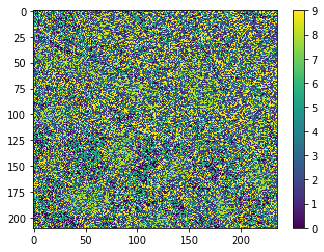

In [188]:
kmeans_image=kmeans.reshape((210,235))
plt.imshow(kmeans_image)
plt.colorbar()

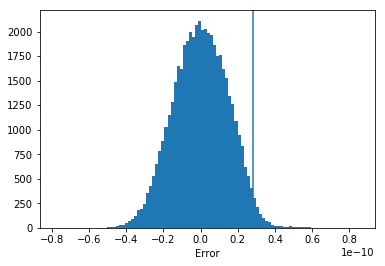

In [127]:
error_list=error.reshape((49350,1))
n, bins, patches=plt.hist(error_list, bins=100, histtype='stepfilled')
plt.axvline(x=0.28e-10)
#plt.axvline(x=0.35e-10)
#plt.axvline(x=0.85e-10)
#plt.xlim(0.2e-10,0.6e-10)
plt.xlabel('Error')

In [109]:
np.std(error_list)

1.4707424833227738e-11

In [113]:
1.47e-11*2

2.94e-11

In [128]:
bins[65]

2.8028976552710721e-11

In [129]:
sum(n[66:])

758.0

In [203]:
x = test_y
y = regr.predict(test_x)


z_test = []
#real - predicted 
#for i in range(9240):
for i in range(len(x)):
    z_test.append(x[i] - y[i])

RSS_test = sum(np.square(z_test))
TSS_test = sum((x - x.mean())**2)
Rsquared_test = 1- (RSS_test/TSS_test)
print(Rsquared_test)

[ 0.54121148]


In [204]:
RSE_test = np.sqrt(RSS_test/(int(x.shape[0])-2))

In [ ]:
RSE_test_test

In [ ]:
#F-statistic 
predictors = 10
Fnumerator = (TSS_test-RSS_test)/predictors
Fdenominator = RSS_test/((int(x.shape[0]))-predictors-1)
F= Fnumerator/Fdenominator
pval=scipy.stats.f.cdf
print(F, 'the p-value generated from the F-statistic is significant at level 0.05.')

## 5. Hyperspectral Unmixing

In [ ]:
hyper_list=hyper.reshape((65536,559))
np.savetxt('spectralmatrix2.txt', hyper_list, delimiter='\t')

In [ ]:
ica = FastICA(n_components=2, max_iter=1000,random_state=0)
#reconstruct signals
S = ica.fit_transform(hyper_list[:,1:]) 
ICA_comp=ica.components_

In [ ]:
plt.plot(exp_wavenumber[11:],ICA_comp[0,10:])
plt.plot(exp_wavenumber[11:],ICA_comp[1,10:])

In [ ]:
np.savetxt('ICA_comp1.txt', ICA_comp[0,10:])
np.savetxt('ICA_comp2.txt', ICA_comp[1,10:])

In [ ]:
NMF_model=NMF(n_components=2, init='random', random_state=0, max_iter=1000)
NMF_fit=NMF_model.fit_transform(hyper_list[:,1:])
NMF_comp=NMF_model.components_

In [ ]:
plt.plot(exp_wavenumber[11:], NMF_comp[0,10:])
plt.plot(exp_wavenumber[11:], NMF_comp[1,10:])

In [ ]:
np.savetxt('NMF_comp1.txt', NMF_comp[0,10:])
np.savetxt('NMF_comp2.txt', NMF_comp[1,10:])
np.savetxt("NMF_wavenumber.txt", exp_wavenumber[11:])

## SI Figures and Plots

In [201]:
select_kmeans=np.zeros((210,235))
k=7
for x in range(int(kmeans_image.shape[0])):
    for y in range(int(kmeans_image.shape[1])):
        if kmeans_image[x,y] == k:
            select_kmeans[x,y]=k
        else: 
            select_kmeans[x,y]=select_kmeans[x,y]

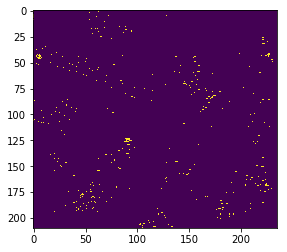

In [202]:
plt.imshow(select_kmeans)

In [123]:
masked_error=np.zeros((210,235))
thresh_error=.28e-10
for x in range(int(error.shape[0])):
    for y in range(int((error.shape[1]))):
        if error[x,y] > thresh_error:
            masked_error[x,y]=hypertopo[x+35,y+10]
        else:
            masked_error[x,y]=masked_error[x,y]

no_p3ht_spectra=np.count_nonzero(masked_error)
p3ht_spectra=np.zeros((no_p3ht_spectra, 559))
counter=0
for x in range(int(error.shape[0])):
    for y in range(int((error.shape[1]))):
        if error[x,y] > thresh_error:
            p3ht_spectra[counter]=hyper[x+35,y+10]
            counter+=1
avg_p3ht=np.average(p3ht_spectra, axis=0)

In [116]:
masked_hyper=np.zeros((210,235))
hyper_thres=0.0001
for x in range(int(error.shape[0])):
    for y in range(int((error.shape[1]))):
        if hyperint[x+35,y+10] < hyper_thres:
            masked_hyper[x,y]=hyperint[x+35,y+10]
        else:
            masked_hyper[x,y]=masked_hyper[x,y]

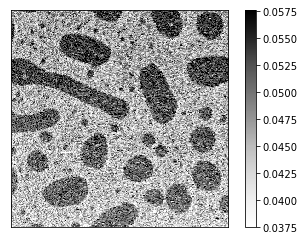

In [148]:
show(hyperslice(hyperimage, start=760, stop=1875), cmap="Greys")

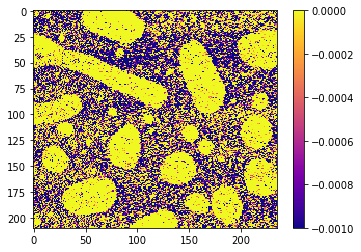

In [96]:
fig=plt.imshow(masked_hyper, cmap="plasma")
plt.colorbar()
plt.clim(-0.001,0)
plt.savefig('masked_hyper.svg', format='svg', dpi=800)

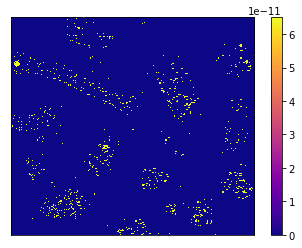

In [124]:
fig=plt.imshow(masked_error, cmap='plasma')
plt.colorbar()
plt.clim(0e-11,6.5e-11)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('masked_error.svg', format='svg', dpi=800)

In [98]:
pmma_reg=np.zeros((210,235))
thresh_cond=6.0e-11
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] < thresh_cond:
            pmma_reg[x,y]=cAFMpredimage[x,y]
        else:
            pmma_reg[x,y]=pmma_reg[x,y]
no_pmma_spectra=np.count_nonzero(pmma_reg)
pmma_spectra=np.zeros((no_pmma_spectra, 559))
counter=0
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] < thresh_cond:
            pmma_spectra[counter]=hyper[x+35,y+10]
            counter+=1
avg_pmma=np.average(pmma_spectra, axis=0)

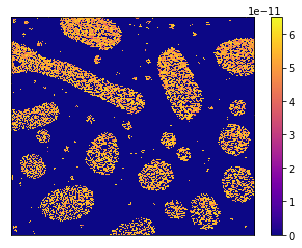

In [99]:
fig=plt.imshow(pmma_reg, cmap='plasma')
plt.colorbar()
plt.clim(0,6.5e-11)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('pmma_mask.svg', format='svg', dpi=800)

In [100]:
#p3ht reg
p3htmatrix_reg=np.zeros((210,235))
thresh_cond=8.2e-11
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] > thresh_cond:
            p3htmatrix_reg[x,y]=cAFMpredimage[x,y]
        else:
            p3htmatrix_reg[x,y]=p3htmatrix_reg[x,y]
no_p3htmatrix_spectra=np.count_nonzero(p3htmatrix_reg)
p3htmatrix_spectra=np.zeros((no_p3htmatrix_spectra, 559))
counter=0
for x in range(int(cAFMpredimage.shape[0])):
    for y in range(int((cAFMpredimage.shape[1]))):
        if cAFMpredimage[x,y] > thresh_cond:
            p3htmatrix_spectra[counter]=hyper[x+35,y+10]
            counter+=1
avg_p3htmatrix=np.average(p3htmatrix_spectra, axis=0)

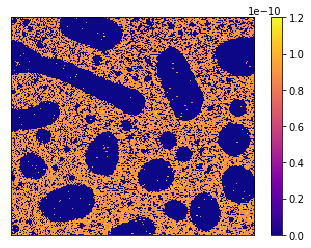

In [101]:
fig=plt.imshow(p3htmatrix_reg, cmap='plasma')
plt.colorbar()
plt.clim(0,1.2e-10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('p3htmatrix_mask.svg', format='svg', dpi=800)

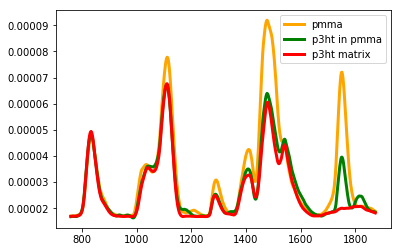

In [145]:
#start15, stop 100
start=1
stop=559
plt.plot(exp_wavenumber[start:stop],avg_pmma[start:stop], color="orange", linewidth=3, label="pmma")
plt.plot(exp_wavenumber[start:stop],avg_p3ht[start:stop], color="green", linewidth=3, label="p3ht in pmma")
plt.plot(exp_wavenumber[start:stop], avg_p3htmatrix[start:stop], color="red", linewidth=3, label="p3ht matrix")
plt.legend()

In [146]:
np.savetxt("wavenumber_full.txt", exp_wavenumber[start:stop], delimiter='\t')
np.savetxt("avg_pmma.txt", avg_pmma[start:stop], delimiter='\t')
np.savetxt("avg_p3htmatrix.txt", avg_p3htmatrix[start:stop], delimiter='\t')
np.savetxt("avg_p3htINpmma.txt", avg_p3ht[start:stop], delimiter='\t')

In [ ]:
#principal component 
plt.figure(figsize=(20,10))

ax1=plt.subplot(5,2,1)
ax1.plot(exp_wavenumber, PCA.components_[5,:], 'black', linewidth=2)
ax1.set_xticklabels([])
#ax1.set_ylabel('PC10')
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3)
ax1.xaxis.set_tick_params(width=3)
ax1.yaxis.set_tick_params(width=3)
ax1.tick_params(axis='both', which='major', labelsize=14)


ax2=plt.subplot(5,2,2)
ax2.plot(exp_wavenumber, PCA.components_[10,:], 'black', linewidth=2)
ax2.set_xticklabels([])
#ax2.set_ylabel('PC11')
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3)
ax2.xaxis.set_tick_params(width=3)
ax2.yaxis.set_tick_params(width=3)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3=plt.subplot(5,2,3)
ax3.plot(exp_wavenumber, PCA.components_[15,:], 'black', linewidth=2)
ax3.set_xticklabels([])
#ax3.set_ylabel('PC12')
for axis in ['top','bottom','left','right']:
  ax3.spines[axis].set_linewidth(3)
ax3.xaxis.set_tick_params(width=3)
ax3.yaxis.set_tick_params(width=3)
ax3.tick_params(axis='both', which='major', labelsize=14)


ax4=plt.subplot(5,2,4)
ax4.plot(exp_wavenumber, PCA.components_[20,:], 'black', linewidth=2)
ax4.set_xticklabels([])
for axis in ['top','bottom','left','right']:
  ax4.spines[axis].set_linewidth(3)
ax4.xaxis.set_tick_params(width=3)
ax4.yaxis.set_tick_params(width=3)
ax4.tick_params(axis='both', which='major', labelsize=14)

ax5=plt.subplot(5,2,5)
ax5.plot(exp_wavenumber, PCA.components_[25,:], 'black', linewidth=2)
ax5.set_xticklabels([])
for axis in ['top','bottom','left','right']:
  ax5.spines[axis].set_linewidth(3)
ax5.xaxis.set_tick_params(width=3)
ax5.yaxis.set_tick_params(width=3)
ax5.tick_params(axis='both', which='major', labelsize=14)


ax6=plt.subplot(5,2,6)
ax6.plot(exp_wavenumber, PCA.components_[30,:], 'black', linewidth=2)
ax6.set_xticklabels([])
for axis in ['top','bottom','left','right']:
  ax6.spines[axis].set_linewidth(3)
ax6.xaxis.set_tick_params(width=3)
ax6.yaxis.set_tick_params(width=3)
ax6.tick_params(axis='both', which='major', labelsize=14)

ax7=plt.subplot(5,2,7)
ax7.plot(exp_wavenumber, PCA.components_[35,:], 'black', linewidth=1.60)
ax7.set_xticklabels([])
for axis in ['top','bottom','left','right']:
  ax7.spines[axis].set_linewidth(3)
ax7.xaxis.set_tick_params(width=3)
ax7.yaxis.set_tick_params(width=3)
ax7.tick_params(axis='both', which='major', labelsize=14)
ax7.set_ylim(-0.1,0.1)


ax8=plt.subplot(5,2,8)
ax8.plot(exp_wavenumber, PCA.components_[140,:], 'black', linewidth=2)
ax8.set_xticklabels([])
for axis in ['top','bottom','left','right']:
  ax8.spines[axis].set_linewidth(3)
ax8.xaxis.set_tick_params(width=3)
ax8.yaxis.set_tick_params(width=3)
ax8.tick_params(axis='both', which='major', labelsize=14)

ax9=plt.subplot(5,2,9)
ax9.plot(exp_wavenumber, PCA.components_[45,:], 'black', linewidth=2)
for axis in ['top','bottom','left','right']:
  ax9.spines[axis].set_linewidth(3)
ax9.xaxis.set_tick_params(width=3)
ax9.yaxis.set_tick_params(width=3)
ax9.tick_params(axis='both', which='major', labelsize=16)
ax9.set_xlabel('Wavenumber (cm$^{-1}$)', size=16)

ax10=plt.subplot(5,2,10)
ax10.plot(exp_wavenumber, PCA.components_[50,:], 'black', linewidth=2)
for axis in ['top','bottom','left','right']:
  ax10.spines[axis].set_linewidth(3)
ax10.xaxis.set_tick_params(width=3)
ax10.yaxis.set_tick_params(width=3)
ax10.tick_params(axis='both', which='major', labelsize=16)
ax10.set_xlabel('Wavenumber (cm$^{-1}$)', size=16)
#plt.tight_layout()